In [1]:
import warnings 
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import json

2024-04-27 13:56:39.660159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 13:56:39.660257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 13:56:39.795229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Check if GPU is available or not

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available, using CPU instead.")

Using GPU: /physical_device:GPU:0


#### Loading a file with preprocessed purchase sequences of users with at least 3 purchased products

In [3]:
with open('/kaggle/input/users-sequences/users_sequences.json', 'r') as file:
    users_sequences = json.load(file)

print('Number of users/sequences in total:', len(users_sequences))

Number of users/sequences in total: 601263


In [4]:
parameters = {}
parameters['number_of_users_in_total'] = len(users_sequences)
parameters['number_of_sequences_in_total'] = len(users_sequences)

#### Filtering sequences in which at least min_num_of_products_in_sequence of products were purchased, i.e. users who purchased at least min_num_of_products_in_sequence of products

In [5]:
min_num_of_products_in_sequence = 5
filtered_users_sequences = {}

for key, value in users_sequences.items():
    if len(value) >= min_num_of_products_in_sequence:
        filtered_users_sequences[key] = value

print('Number of users/sequences after filtering:', len(filtered_users_sequences))

Number of users/sequences after filtering: 252156


In [6]:
parameters['number_of_sequences_after_filtering'] = len(filtered_users_sequences)
parameters['number_of_users_after_filtering'] = len(filtered_users_sequences)

#### Creating sequences of length sequence_length and splitting the sequences into train, validation and test datasets, so that the last sequence is selected into the test dataset, the penultimate sequence is selected into the validation dataset and all previous ones are selected into the train dataset. Padding with a value of 0 is applied to keep the sequence length equal to sequence_length

In [7]:
sequence_length = 40

def generate_and_split_sequences(data):
    train_sequences = []
    validation_sequences = []
    test_sequences = []
    train_targets = []
    validation_targets = []
    test_targets = []
    train_user_ids = []
    validation_user_ids = []
    test_user_ids = []

    for user_id, products in data.items():
        n = len(products)
        if n < 2:
            continue

        sequences = []
        for i in range(1, n):
            current_seq = products[:i]
            if len(current_seq) < sequence_length:
                padded_seq = [0] * (sequence_length - len(current_seq)) + current_seq
                sequences.append(padded_seq)
            else:
                sequences.append(current_seq[-sequence_length:])

        targets = products[1:]

        if len(sequences) >= 2:
            train_sequences.extend(sequences[:-2])
            train_targets.extend(targets[:-2])
            train_user_ids.extend([user_id] * (len(sequences) - 2))

            validation_sequences.append(sequences[-2])
            validation_targets.append(targets[-2])
            validation_user_ids.append(user_id)

            test_sequences.append(sequences[-1])
            test_targets.append(targets[-1])
            test_user_ids.append(user_id)
        elif len(sequences) == 1:
            test_sequences.append(sequences[0])
            test_targets.append(targets[0])
            test_user_ids.append(user_id)

    return {
        'train': (train_sequences, train_targets, train_user_ids),
        'validation': (validation_sequences, validation_targets, validation_user_ids),
        'test': (test_sequences, test_targets, test_user_ids)
    }

datasets = generate_and_split_sequences(filtered_users_sequences)

In [8]:
parameters['sequence_length'] = sequence_length

#### Assigning obtained datasets to a clearer form

In [9]:
X_train = datasets['train'][0]
y_train = datasets['train'][1]

X_val = datasets['validation'][0]
y_val = datasets['validation'][1]

X_test = datasets['test'][0]
y_test = datasets['test'][1]

print("An example of what sequences and targets look like:\n\nSequences:\n", X_train[-10:])
print("\nTargets:\n", y_train[-10:])

An example of what sequences and targets look like:

Sequences:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657, 39579], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089], [0, 0,

In [10]:
print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

Number of train sequences: 1489192
Number of validation sequences: 252156
Number of test sequences: 252156

Number of train targets: 1489192
Number of validation targets: 252156
Number of test targets: 252156


In [11]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

#### Preprocessing datasets for faster processing

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [13]:
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### F1@k

In [15]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [16]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [17]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

#### Getting the highest product ID value for input_dim in Embedding layers

In [18]:
max_product_id = float('-inf')

for user, sequences in filtered_users_sequences.items():
    current_max = max(sequences)
    if current_max > max_product_id:
        max_product_id = current_max

max_product_id

144605

-------

# Training and evaluating models

## LSTM

In [19]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [20]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
    8/23269 ━━━━━━━━━━━━━━━━━━━━ 6:32 17ms/step - accuracy: 0.0000e+00 - f1_score_at_k: 5.5959e-04 - hit_rate_at_k: 0.0016 - loss: 11.8817 - ndcg_at_k: 2.8591e-04     

I0000 00:00:1714226479.250997     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 398s 17ms/step - accuracy: 0.0343 - f1_score_at_k: 0.0295 - hit_rate_at_k: 0.0586 - loss: 9.6712 - ndcg_at_k: 0.0159 - val_accuracy: 0.0540 - val_f1_score_at_k: 0.0599 - val_hit_rate_at_k: 0.0731 - val_loss: 9.5806 - val_ndcg_at_k: 0.0218
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 376s 16ms/step - accuracy: 0.0574 - f1_score_at_k: 0.0611 - hit_rate_at_k: 0.0886 - loss: 9.0426 - ndcg_at_k: 0.0251 - val_accuracy: 0.0673 - val_f1_score_at_k: 0.0710 - val_hit_rate_at_k: 0.0864 - val_loss: 9.4614 - val_ndcg_at_k: 0.0263
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 377s 16ms/step - accuracy: 0.0673 - f1_score_at_k: 0.0709 - hit_rate_at_k: 0.1003 - loss: 8.8542 - ndcg_at_k: 0.0287 - val_accuracy: 0.0727 - val_f1_score_at_k: 0.0743 - val_hit_rate_at_k: 0.0912 - val_loss: 9.4058 - val_ndcg_at_k: 0.0280
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 379s 16ms/step - accuracy: 0.0736 - f1_score_at_k: 0.0765 - hit_rate_at_k: 0.1065 - loss: 8.7391 - ndcg_at_k: 0.0308 -

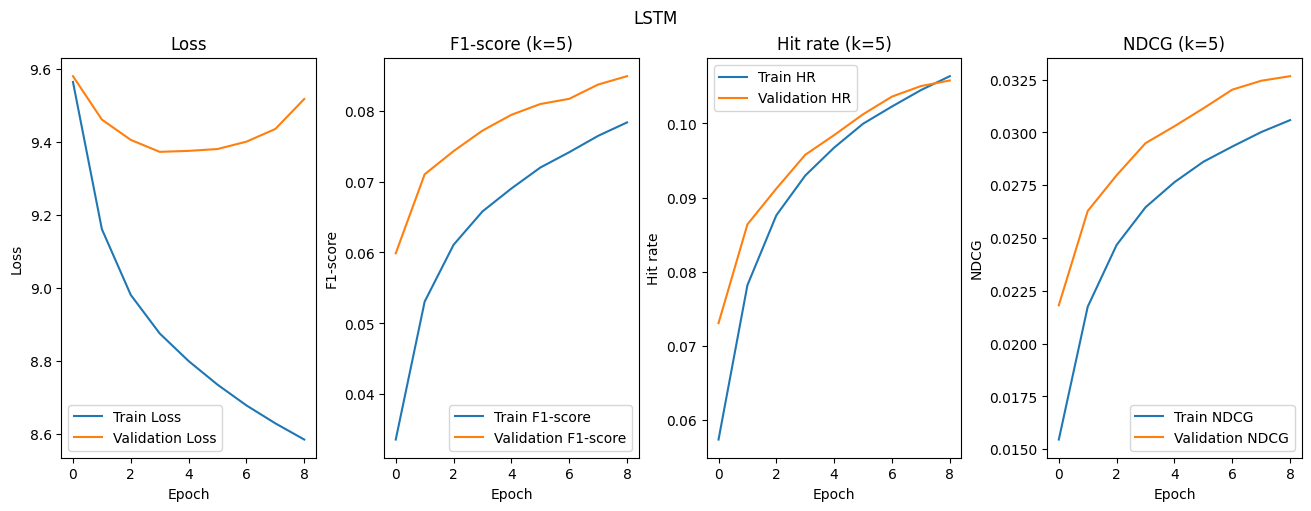

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('LSTM')
plt.show()

In [22]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score"] = round(model_lstm_test_f1_score, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.0783 - f1_score_at_k: 0.0790 - hit_rate_at_k: 0.0947 - loss: nan - ndcg_at_k: 0.0295
Test loss: nan
Test accuracy: 0.0632
Test F1@5: 0.0644
Test HR@5: 0.0787
Test NDCG@5: 0.0242


In [23]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 40,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0632,
 'model_lstm_test_f1_score': 0.0644,
 'model_lstm_test_hr': 0.0787,
 'model_lstm_test_ndcg': 0.0242}

---------

## Bidirectional-LSTM

In [24]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [25]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 627s 26ms/step - accuracy: 0.0382 - f1_score_at_k: 0.0352 - hit_rate_at_k: 0.0632 - loss: 9.6253 - ndcg_at_k: 0.0174 - val_accuracy: 0.0584 - val_f1_score_at_k: 0.0649 - val_hit_rate_at_k: 0.0783 - val_loss: 9.4974 - val_ndcg_at_k: 0.0235
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 589s 25ms/step - accuracy: 0.0680 - f1_score_at_k: 0.0708 - hit_rate_at_k: 0.0980 - loss: 8.9222 - ndcg_at_k: 0.0285 - val_accuracy: 0.0717 - val_f1_score_at_k: 0.0713 - val_hit_rate_at_k: 0.0871 - val_loss: 9.3786 - val_ndcg_at_k: 0.0271
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 570s 24ms/step - accuracy: 0.0782 - f1_score_at_k: 0.0779 - hit_rate_at_k: 0.1068 - loss: 8.7526 - ndcg_at_k: 0.0317 - val_accuracy: 0.0772 - val_f1_score_at_k: 0.0759 - val_hit_rate_at_k: 0.0932 - val_loss: 9.3427 - val_ndcg_at_k: 0.0291
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 574s 25ms/step - accuracy: 0.0845 - f1_score_at_k: 0.0828 - hit_rate_at_k: 0.1122 - loss: 8.6536 - ndcg_at_

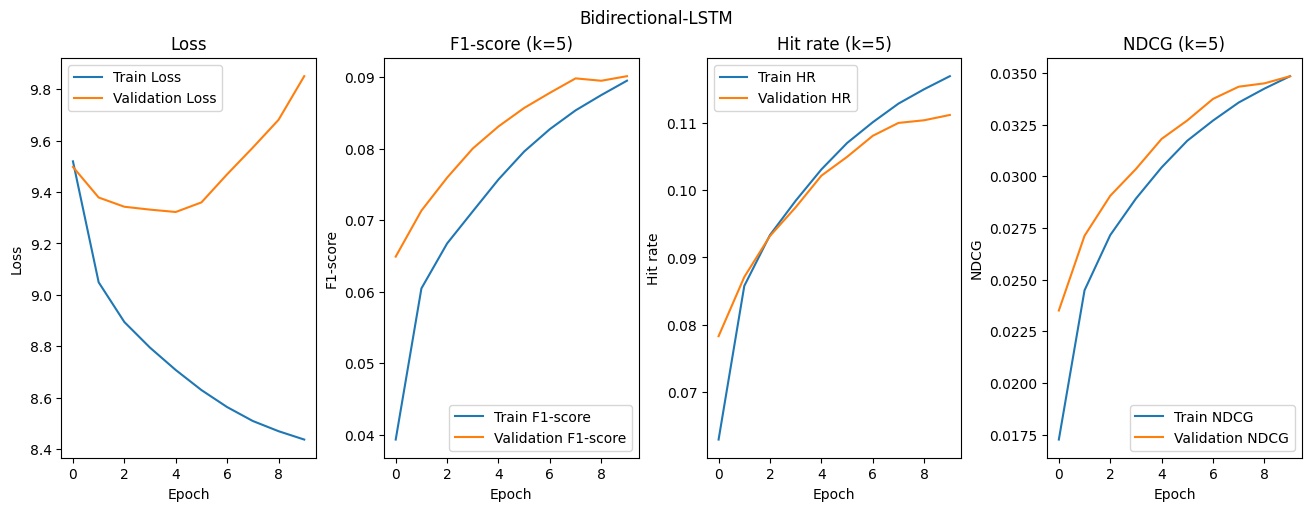

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [27]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score"] = round(model_bi_lstm_test_f1_score, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.0862 - f1_score_at_k: 0.0832 - hit_rate_at_k: 0.0994 - loss: nan - ndcg_at_k: 0.0316
Test loss: nan
Test accuracy: 0.07
Test F1@5: 0.0685
Test HR@5: 0.083
Test NDCG@5: 0.0261


In [28]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 40,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0632,
 'model_lstm_test_f1_score': 0.0644,
 'model_lstm_test_hr': 0.0787,
 'model_lstm_test_ndcg': 0.0242,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.07,
 'model_bi_lstm_test_f1_score': 0.0685,
 'model_bi_lstm_test_hr': 0.083,
 'model_bi_lstm_test_ndcg': 0.0261}

-----------

## GRU

In [29]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [30]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 420s 18ms/step - accuracy: 0.0348 - f1_score_at_k: 0.0312 - hit_rate_at_k: 0.0602 - loss: 9.6675 - ndcg_at_k: 0.0163 - val_accuracy: 0.0510 - val_f1_score_at_k: 0.0571 - val_hit_rate_at_k: 0.0709 - val_loss: 9.6107 - val_ndcg_at_k: 0.0210
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 401s 17ms/step - accuracy: 0.0536 - f1_score_at_k: 0.0572 - hit_rate_at_k: 0.0845 - loss: 9.0963 - ndcg_at_k: 0.0237 - val_accuracy: 0.0593 - val_f1_score_at_k: 0.0642 - val_hit_rate_at_k: 0.0798 - val_loss: 9.5041 - val_ndcg_at_k: 0.0239
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 394s 17ms/step - accuracy: 0.0610 - f1_score_at_k: 0.0660 - hit_rate_at_k: 0.0947 - loss: 8.9119 - ndcg_at_k: 0.0267 - val_accuracy: 0.0678 - val_f1_score_at_k: 0.0707 - val_hit_rate_at_k: 0.0872 - val_loss: 9.4269 - val_ndcg_at_k: 0.0264
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 392s 17ms/step - accuracy: 0.0667 - f1_score_at_k: 0.0708 - hit_rate_at_k: 0.1002 - loss: 8.8149 - ndcg_at_

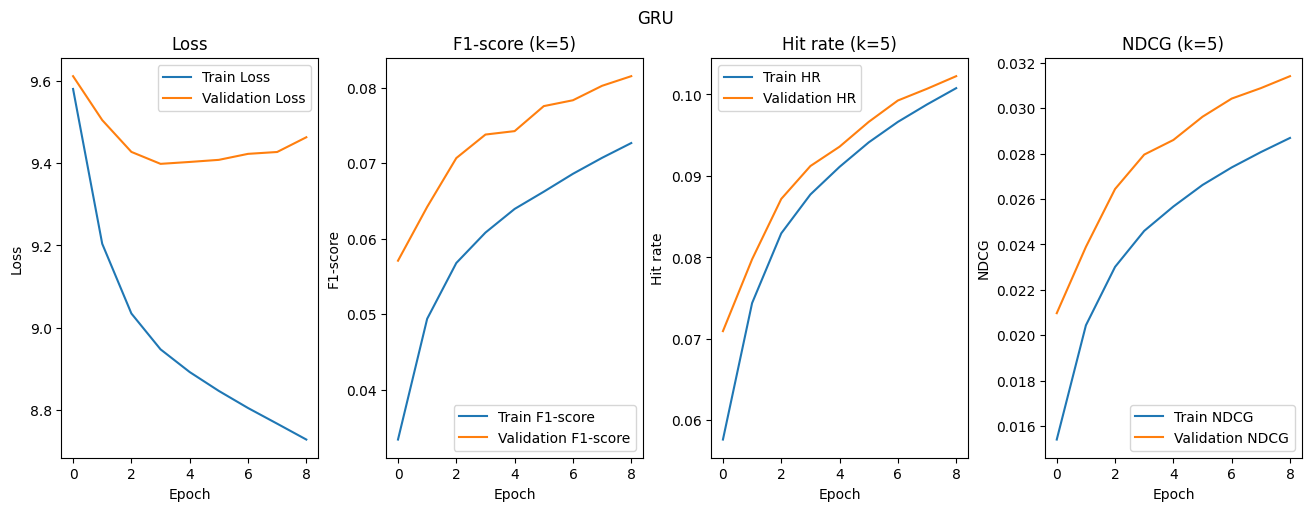

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('GRU')
plt.show()

In [32]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@5:", round(model_gru_test_f1_score, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score"] = round(model_gru_test_f1_score, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.0755 - f1_score_at_k: 0.0761 - hit_rate_at_k: 0.0912 - loss: nan - ndcg_at_k: 0.0284
Test loss: nan
Test accuracy: 0.0601
Test F1@5: 0.0621
Test HR@5: 0.0754
Test NDCG@5: 0.0231


In [33]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 40,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0632,
 'model_lstm_test_f1_score': 0.0644,
 'model_lstm_test_hr': 0.0787,
 'model_lstm_test_ndcg': 0.0242,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.07,
 'model_bi_lstm_test_f1_score': 0.0685,
 'model_bi_lstm_test_hr': 0.083,
 'model_bi_lstm_test_ndcg': 0.0261,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.0601,
 'model_gru_test_f1_score': 0.0621,
 'model_gru_test_hr': 0.0754,
 'model_gru_test_ndcg': 0.0231}

--------

## Autoencoder

In [34]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [35]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
   21/23269 ━━━━━━━━━━━━━━━━━━━━ 3:08 8ms/step - accuracy: 0.0000e+00 - f1_score_at_k: 1.0058e-04 - hit_rate_at_k: 1.8443e-04 - loss: 11.8836 - ndcg_at_k: 2.8488e-05  

W0000 00:00:1714239454.461974     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0234 - f1_score_at_k: 0.0167 - hit_rate_at_k: 0.0457 - loss: 9.8113 - ndcg_at_k: 0.0119

W0000 00:00:1714239651.661232     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 226s 9ms/step - accuracy: 0.0234 - f1_score_at_k: 0.0167 - hit_rate_at_k: 0.0457 - loss: 9.8112 - ndcg_at_k: 0.0119 - val_accuracy: 0.0383 - val_f1_score_at_k: 0.0474 - val_hit_rate_at_k: 0.0632 - val_loss: 9.4202 - val_ndcg_at_k: 0.0174
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 201s 9ms/step - accuracy: 0.0395 - f1_score_at_k: 0.0429 - hit_rate_at_k: 0.0751 - loss: 8.9730 - ndcg_at_k: 0.0197 - val_accuracy: 0.0457 - val_f1_score_at_k: 0.0591 - val_hit_rate_at_k: 0.0757 - val_loss: 9.3191 - val_ndcg_at_k: 0.0208
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 202s 9ms/step - accuracy: 0.0480 - f1_score_at_k: 0.0544 - hit_rate_at_k: 0.0864 - loss: 8.8640 - ndcg_at_k: 0.0231 - val_accuracy: 0.0542 - val_f1_score_at_k: 0.0656 - val_hit_rate_at_k: 0.0837 - val_loss: 9.3648 - val_ndcg_at_k: 0.0235
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 203s 9ms/step - accuracy: 0.0526 - f1_score_at_k: 0.0603 - hit_rate_at_k: 0.0927 - loss: 8.8130 - ndcg_at_k: 0.0249 - val

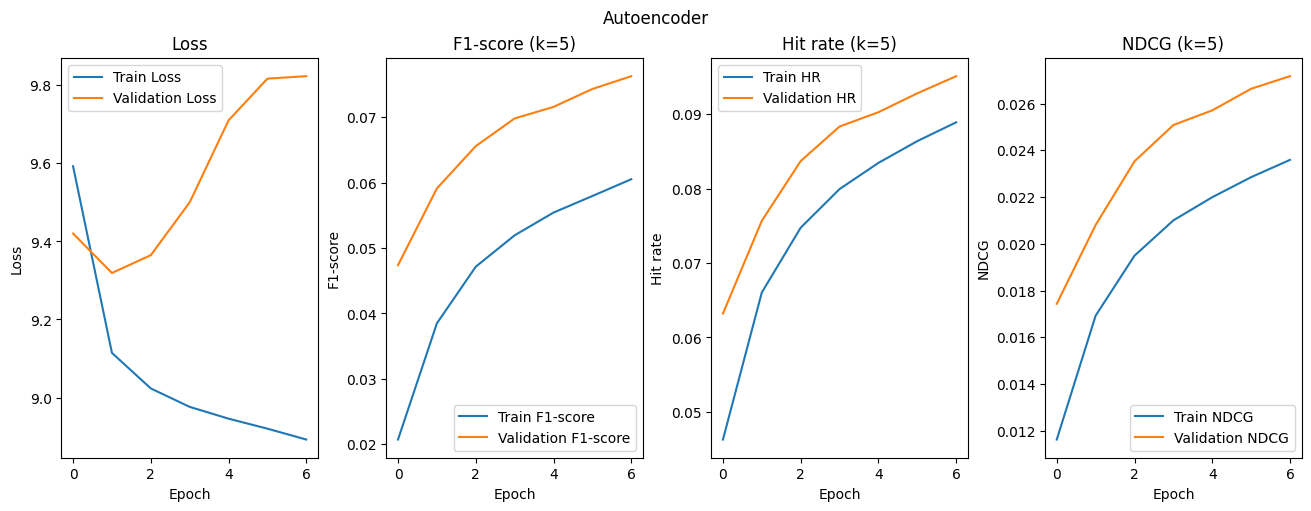

In [36]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Autoencoder')
plt.show()

In [37]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score"] = round(model_autoencoder_test_f1_score, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.0572 - f1_score_at_k: 0.0728 - hit_rate_at_k: 0.0855 - loss: nan - ndcg_at_k: 0.0246
Test loss: nan
Test accuracy: 0.0435
Test F1@5: 0.0579
Test HR@5: 0.0693
Test NDCG@5: 0.0194


In [38]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 40,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0632,
 'model_lstm_test_f1_score': 0.0644,
 'model_lstm_test_hr': 0.0787,
 'model_lstm_test_ndcg': 0.0242,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.07,
 'model_bi_lstm_test_f1_score': 0.0685,
 'model_bi_lstm_test_hr': 0.083,
 'model_bi_lstm_test_ndcg': 0.0261,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.0601,
 'model_gru_test_f1_score': 0.0621,
 'model_gru_test_hr': 0.0754,
 'model_gru_test_ndcg': 0.0231,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.0435,
 'model_autoencoder_test_f1_score': 0.0579,
 'model_autoenc

-------

## CNN

In [39]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
#model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(max_product_id, activation='softmax'))

model_cnn.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [40]:
history_model_cnn = model_cnn.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 186s 8ms/step - accuracy: 0.0402 - f1_score_at_k: 0.0342 - hit_rate_at_k: 0.0628 - loss: 9.6058 - ndcg_at_k: 0.0177 - val_accuracy: 0.0537 - val_f1_score_at_k: 0.0568 - val_hit_rate_at_k: 0.0723 - val_loss: 9.6033 - val_ndcg_at_k: 0.0216
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 174s 7ms/step - accuracy: 0.0641 - f1_score_at_k: 0.0638 - hit_rate_at_k: 0.0924 - loss: 8.9732 - ndcg_at_k: 0.0268 - val_accuracy: 0.0620 - val_f1_score_at_k: 0.0642 - val_hit_rate_at_k: 0.0804 - val_loss: 9.7110 - val_ndcg_at_k: 0.0244
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 174s 7ms/step - accuracy: 0.0748 - f1_score_at_k: 0.0721 - hit_rate_at_k: 0.1023 - loss: 8.7864 - ndcg_at_k: 0.0303 - val_accuracy: 0.0697 - val_f1_score_at_k: 0.0705 - val_hit_rate_at_k: 0.0874 - val_loss: 10.2167 - val_ndcg_at_k: 0.0268
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 172s 7ms/step - accuracy: 0.0811 - f1_score_at_k: 0.0780 - hit_rate_at_k: 0.1090 - loss: 8.6662 - ndcg_at_k: 

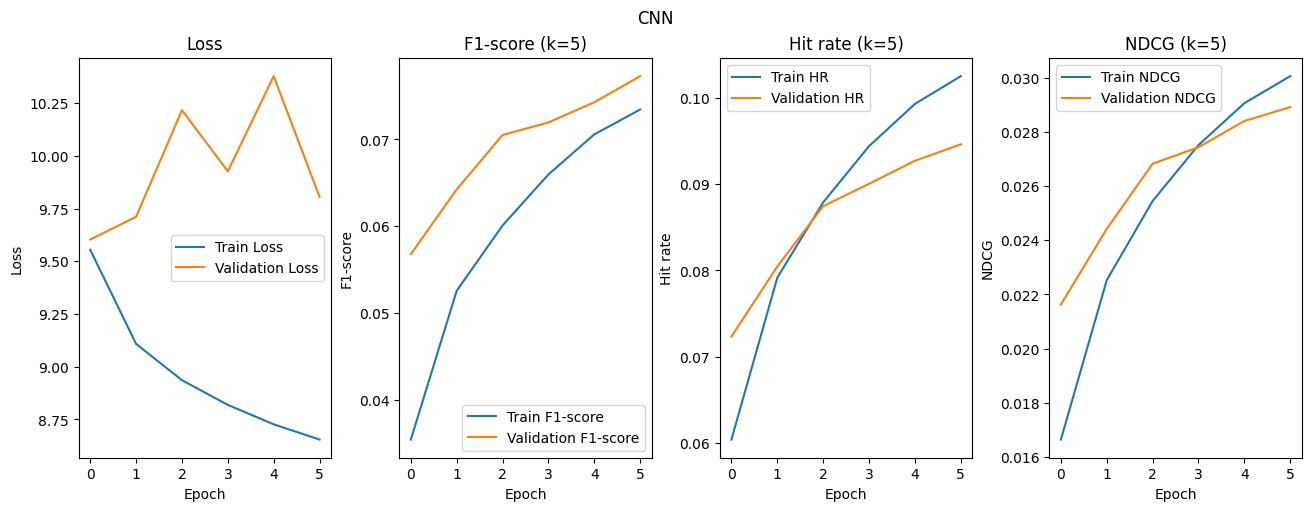

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_cnn.history['loss'], label='Train Loss')
ax1.plot(history_model_cnn.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_cnn.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_cnn.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_cnn.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_cnn.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_cnn.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_cnn.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('CNN')
plt.show()

In [42]:
model_cnn_test_loss, model_cnn_test_accuracy, model_cnn_test_f1_score, model_cnn_test_hr, model_cnn_test_ndcg = model_cnn.evaluate(test_dataset)

print("Test loss:", round(model_cnn_test_loss, 4))
print("Test accuracy:", round(model_cnn_test_accuracy, 4))
print("Test F1@5:", round(model_cnn_test_f1_score, 4))
print("Test HR@5:", round(model_cnn_test_hr, 4))
print("Test NDCG@5:", round(model_cnn_test_ndcg, 4))

parameters["model_cnn_test_loss"] = model_cnn_test_loss
parameters["model_cnn_test_accuracy"] = round(model_cnn_test_accuracy, 4)
parameters["model_cnn_test_f1_score"] = round(model_cnn_test_f1_score, 4)
parameters["model_cnn_test_hr"] = round(model_cnn_test_hr, 4)
parameters["model_cnn_test_ndcg"] = round(model_cnn_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.0677 - f1_score_at_k: 0.0712 - hit_rate_at_k: 0.0849 - loss: nan - ndcg_at_k: 0.0261
Test loss: nan
Test accuracy: 0.0525
Test F1@5: 0.0564
Test HR@5: 0.0685
Test NDCG@5: 0.0207


------

In [43]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 40,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0632,
 'model_lstm_test_f1_score': 0.0644,
 'model_lstm_test_hr': 0.0787,
 'model_lstm_test_ndcg': 0.0242,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.07,
 'model_bi_lstm_test_f1_score': 0.0685,
 'model_bi_lstm_test_hr': 0.083,
 'model_bi_lstm_test_ndcg': 0.0261,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.0601,
 'model_gru_test_f1_score': 0.0621,
 'model_gru_test_hr': 0.0754,
 'model_gru_test_ndcg': 0.0231,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.0435,
 'model_autoencoder_test_f1_score': 0.0579,
 'model_autoenc